# My bounding box implementation

**Steps:**
1. Prepare the data and visualization [DONE]
    1. Create image lists with annotations, bbs [DONE]
    2. Create plotting functions [DONE]
2. Largest object classifier
    1. Get the largest item and save appropriate CSV file
    2. Train a pretrained classifier
    3. Check out how well it does
3. Bounding box only regression problem
    1. Prepare the data and save as CSV file
    2. Train a pretrained classifier
    3. Check out how well it does
4. Combine the two for a single object detector

In [1]:
%load_ext autoreload
%autoreload 2

In [97]:
%matplotlib inline
from fastai.imports import *
from fastai.conv_learner import *
from fastai.dataset import *
from matplotlib import patches, patheffects

## Prepare the data

Use pathlib!

In [3]:
PATH = Path('data/pascal/')

In [6]:
list(PATH.iterdir())

[PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/VOC2007'),
 PosixPath('data/pascal/VOCtrainval_11-May-2012.tar'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/VOC2012')]

In [69]:
!ls {PATH}/VOC2007/JPEGImages

000005.jpg  001688.jpg	003320.jpg  005004.jpg	006638.jpg  008307.jpg
000007.jpg  001689.jpg	003325.jpg  005006.jpg	006643.jpg  008310.jpg
000009.jpg  001690.jpg	003327.jpg  005007.jpg	006645.jpg  008311.jpg
000012.jpg  001691.jpg	003330.jpg  005014.jpg	006647.jpg  008312.jpg
000016.jpg  001693.jpg	003331.jpg  005016.jpg	006648.jpg  008313.jpg
000017.jpg  001699.jpg	003335.jpg  005018.jpg	006652.jpg  008315.jpg
000019.jpg  001707.jpg	003336.jpg  005020.jpg	006654.jpg  008316.jpg
000020.jpg  001708.jpg	003337.jpg  005023.jpg	006657.jpg  008317.jpg
000021.jpg  001711.jpg	003338.jpg  005024.jpg	006658.jpg  008318.jpg
000023.jpg  001713.jpg	003339.jpg  005026.jpg	006660.jpg  008319.jpg
000024.jpg  001714.jpg	003343.jpg  005027.jpg	006661.jpg  008320.jpg
000026.jpg  001717.jpg	003344.jpg  005028.jpg	006664.jpg  008322.jpg
000030.jpg  001718.jpg	003349.jpg  005029.jpg	006666.jpg  008323.jpg
000032.jpg  001721.jpg	003350.jpg  005032.jpg	006667.jpg  008326.jpg
000033.jpg  001723.jpg	003351.jpg 

### Create image lists with annotations and bbs

In [9]:
# Load the 2007 train json file
train_json = json.load((PATH/'pascal_train2007.json').open())

In [15]:
train_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [45]:
IMAGES, ANNOTATIONS, IMAGE_ID, BBOX = 'images', 'annotations', 'image_id', 'bbox'

In [33]:
train_json[IMAGES][:3], len(train_json[IMAGES])

([{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
  {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
  {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334}],
 2501)

In [90]:
cats = {d['id']: d['name'] for d in train_json['categories']}; print(cats)

{1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}


In [31]:
train_json['annotations'][:2], len(train_json['annotations'])

([{'area': 34104,
   'bbox': [155, 96, 196, 174],
   'category_id': 7,
   'id': 1,
   'ignore': 0,
   'image_id': 12,
   'iscrowd': 0,
   'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
  {'area': 13110,
   'bbox': [184, 61, 95, 138],
   'category_id': 15,
   'id': 2,
   'ignore': 0,
   'image_id': 17,
   'iscrowd': 0,
   'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}],
 7844)

In [41]:
ann = train_json[ANNOTATIONS][0]

In [42]:
ann

{'area': 34104,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0,
 'image_id': 12,
 'iscrowd': 0,
 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}

In [44]:
ann[IMAGE_ID]

12

In [52]:
# Change rows and columns
# orig annos are col/row/width/height
# convert to upper left row/col bottomright row/col
cov2np = lambda a: [a[1], a[0], a[1]+a[3], a[0]+a[2]]
np2cov = lambda a: [a[1], a[0], a[3]-a[1], a[2]-a[0]]

In [63]:
train_annos = collections.defaultdict(lambda: [])
for ann in train_json[ANNOTATIONS]:
    train_annos[ann[IMAGE_ID]].append([cov2np(ann['bbox']), ann['category_id']])

In [98]:
train_annos

defaultdict(<function __main__.<lambda>>,
            {12: [[[96, 155, 270, 351], 7]],
             17: [[[61, 184, 199, 279], 15], [[77, 89, 336, 403], 13]],
             23: [[[229, 8, 500, 245], 2],
              [[219, 229, 500, 334], 2],
              [[177, 1, 500, 90], 2],
              [[0, 1, 369, 117], 15],
              [[1, 2, 462, 243], 15],
              [[0, 224, 486, 334], 15]],
             26: [[[124, 89, 212, 337], 7]],
             32: [[[77, 103, 183, 375], 1],
              [[87, 132, 123, 197], 1],
              [[179, 194, 229, 213], 15],
              [[188, 25, 238, 44], 15]],
             33: [[[106, 8, 263, 499], 1],
              [[199, 420, 226, 482], 1],
              [[187, 324, 223, 411], 1]],
             34: [[[166, 115, 400, 360], 19], [[152, 140, 229, 333], 19]],
             35: [[[95, 0, 361, 191], 15],
              [[97, 217, 318, 465], 15],
              [[194, 467, 317, 500], 15],
              [[303, 2, 375, 500], 11]],
             36: [[[78

In [99]:
train_json[IMAGES]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500},
 {'file_name': '000033.jpg', 'height': 366, 'id': 33, 'width': 500},
 {'file_name': '000034.jpg', 'height': 500, 'id': 34, 'width': 360},
 {'file_name': '000035.jpg', 'height': 375, 'id': 35, 'width': 500},
 {'file_name': '000036.jpg', 'height': 500, 'id': 36, 'width': 332},
 {'file_name': '000042.jpg', 'height': 335, 'id': 42, 'width': 500},
 {'file_name': '000044.jpg', 'height': 333, 'id': 44, 'width': 500},
 {'file_name': '000047.jpg', 'height': 333, 'id': 47, 'width': 500},
 {'file_name': '000048.jpg', 'height': 500, 'id': 48, 'width': 375},
 {'file_name': '000061.jpg', 'height': 333, 'id': 61, 'width': 500},
 {'file_name': '000064.jpg', 'heig

In [100]:
train_jpegs = {d['id']: d['file_name'] for d in train_json[IMAGES]}

### Plotting functions

In [92]:
def show_img(im):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(im)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    return ax

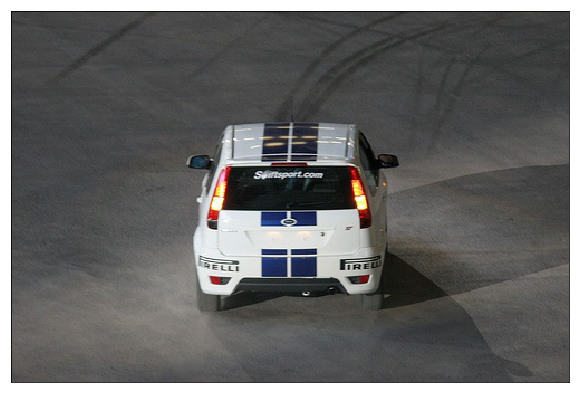

In [93]:
ax = show_img(Image.open(PATH/'VOC2007/JPEGImages'/train_jpegs[0]))

In [82]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

In [83]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [84]:
def draw_text(ax, xy, txt):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=16, weight='bold')
    draw_outline(text, 1)

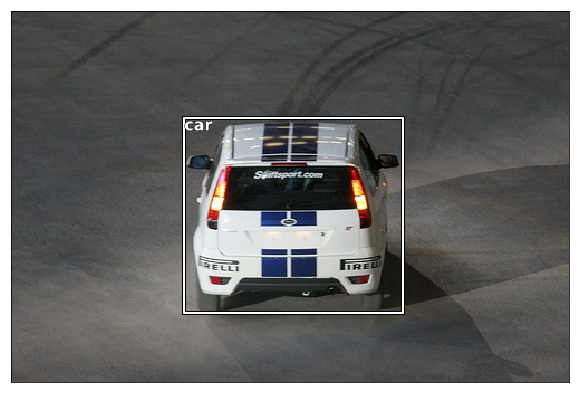

In [94]:
ax = show_img(Image.open(PATH/'VOC2007/JPEGImages'/train_jpegs[0]))
bb_cov = np2cov(train_annos[12][0][0])
draw_rect(ax, bb_cov)
draw_text(ax, bb_cov[:2], cats[train_annos[12][0][1]])

In [95]:
def plot_img_ann(im, ann):
    ax = show_img(im)
    for bb, cat in ann:
        bb_cov = np2cov(bb)
        draw_rect(ax, bb_cov)
        draw_text(ax, bb_cov[:2], cats[cat])

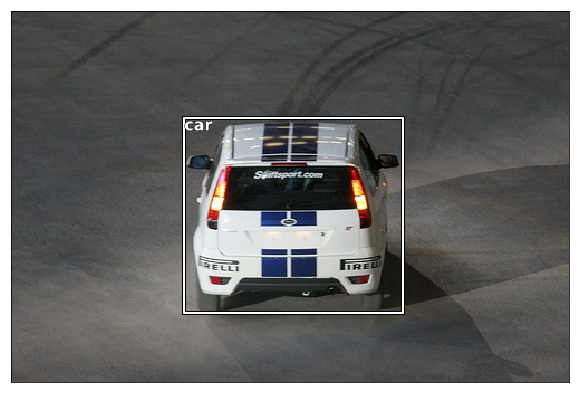

In [96]:
plot_img_ann(Image.open(PATH/'VOC2007/JPEGImages'/train_jpegs[0]), train_annos[12])

In [101]:
def plot_idx(idx):
    im = open_image(PATH/'VOC2007/JPEGImages'/train_jpegs[idx])
    ann = train_annos[idx]
    plot_img_ann(im , ann)

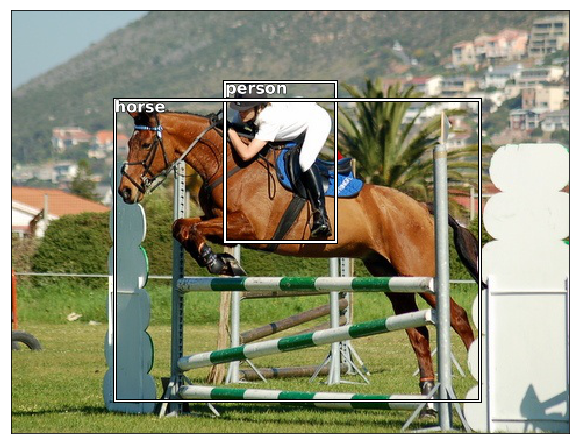

In [102]:
plot_idx(17)

## Largest item detector

### Prepare the dataset

In [104]:
train_annos.items()

dict_items([(12, [[[96, 155, 270, 351], 7]]), (17, [[[61, 184, 199, 279], 15], [[77, 89, 336, 403], 13]]), (23, [[[229, 8, 500, 245], 2], [[219, 229, 500, 334], 2], [[177, 1, 500, 90], 2], [[0, 1, 369, 117], 15], [[1, 2, 462, 243], 15], [[0, 224, 486, 334], 15]]), (26, [[[124, 89, 212, 337], 7]]), (32, [[[77, 103, 183, 375], 1], [[87, 132, 123, 197], 1], [[179, 194, 229, 213], 15], [[188, 25, 238, 44], 15]]), (33, [[[106, 8, 263, 499], 1], [[199, 420, 226, 482], 1], [[187, 324, 223, 411], 1]]), (34, [[[166, 115, 400, 360], 19], [[152, 140, 229, 333], 19]]), (35, [[[95, 0, 361, 191], 15], [[97, 217, 318, 465], 15], [[194, 467, 317, 500], 15], [[303, 2, 375, 500], 11]]), (36, [[[78, 26, 344, 319], 12]]), (42, [[[31, 262, 295, 500], 19], [[35, 0, 299, 235], 19]]), (44, [[[0, 0, 330, 370], 9], [[100, 98, 213, 312], 8]]), (47, [[[0, 14, 312, 459], 7], [[169, 438, 230, 487], 9]]), (48, [[[106, 57, 465, 291], 3], [[0, 1, 500, 302], 15]]), (61, [[[10, 273, 279, 437], 4], [[213, 183, 252, 281],

In [ ]:
def get_largest(anns): 
    